In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# from __future__ import print_function

import os
import sys

import keras
import tensorflow as tf


from object_detector_retinanet.keras_retinanet import models
from object_detector_retinanet.keras_retinanet.preprocessing.csv_generator import CSVGenerator
from object_detector_retinanet.keras_retinanet.utils.predict_iou import predict
from object_detector_retinanet.keras_retinanet.utils.keras_version import check_keras_version
from object_detector_retinanet.utils import image_path, annotation_path, root_dir
from object_detector_retinanet.keras_retinanet.utils.image import preprocess_image

import matplotlib.pyplot as plt

import csv

import datetime

from object_detector_retinanet.keras_retinanet.utils import EmMerger
from object_detector_retinanet.utils import create_folder, root_dir
from object_detector_retinanet.keras_retinanet.utils.visualization import draw_detections, draw_annotations

import numpy as np

import cv2

save_path = "/usr/src/app/predictions/"
hard_score_rate = 0.5
csv_data_lst = []
csv_data_lst.append(['image_id', 'x1', 'y1', 'x2', 'y2', 'confidence', 'hard_score'])
score_threshold = 0.1
max_detections = 9999

Using TensorFlow backend.


In [2]:
model = models.load_model(
    '/usr/src/app/weights/iou_resnet50_csv_06.h5', 
    backbone_name='resnet50', 
    convert=1, 
    nms=False)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We got this warning message when loading the model. 

> /usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
  
We don't know what it means. 

In [48]:
DATA_PATH = '/usr/src/data/'
DATA_PATH = '/usr/src/app/20201117 germany'
DATA_PATH = '/usr/src/app/data/kesko'
generator = CSVGenerator(
            csv_data_file=f'{DATA_PATH}/annotations/annotations_test.csv',
            csv_class_file='/usr/src/app/object_detector_retinanet/keras_retinanet/bin/class_mappings.csv',
            image_min_side=800,
            image_max_side=1333,
            base_dir=f'{DATA_PATH}/images',
        )

100%|██████████| 150/150 [00:00<00:00, 23036.34it/s]

Loading images...


In [49]:
generator.size()

150

In [50]:
i = 2
image_name = os.path.join(generator.image_path(i).split(os.path.sep)[-2],
                                  generator.image_path(i).split(os.path.sep)[-1])
raw_image = generator.load_image(i)
image = generator.preprocess_image(raw_image.copy())
image, scale = generator.resize_image(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


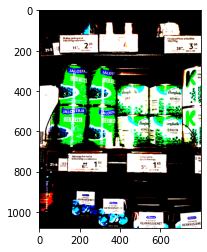

In [51]:
plt.imshow(image)

In [46]:
boxes, hard_scores, labels, soft_scores = model.predict_on_batch(np.expand_dims(image, axis=0))

In [47]:
boxes.shape

(1, 999999, 4)

In [45]:
soft_scores = np.squeeze(soft_scores, axis=-1)
soft_scores = hard_score_rate * hard_scores + (1 - hard_score_rate) * soft_scores
    
boxes /= scale

# select indices which have a score above the threshold
indices = np.where(hard_scores[0, :] > score_threshold)[0]

# select those scores
scores = soft_scores[0][indices]
hard_scores = hard_scores[0][indices]

# find the order with which to sort the scores
scores_sort = np.argsort(-scores)[:max_detections]

# select detections
image_boxes = boxes[0, indices[scores_sort], :]
image_scores = scores[scores_sort]
image_hard_scores = hard_scores[scores_sort]
image_labels = labels[0, indices[scores_sort]]
image_detections = np.concatenate(
    [image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_labels, axis=1)], axis=1)
results = np.concatenate(
    [image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_hard_scores, axis=1),
     np.expand_dims(image_labels, axis=1)], axis=1)
filtered_data = EmMerger.merge_detections(image_name, results)
filtered_boxes = []
filtered_scores = []
filtered_labels = []

for _, detection in filtered_data.iterrows():
    box = np.asarray([detection['x1'], detection['y1'], detection['x2'], detection['y2']])
    filtered_boxes.append(box)
    filtered_scores.append(detection['confidence'])
    filtered_labels.append('{0:.2f}'.format(detection['hard_score']))
    row = [image_name, detection['x1'], detection['y1'], detection['x2'], detection['y2'],
           detection['confidence'], detection['hard_score']]
    csv_data_lst.append(row)

if save_path is not None:
    create_folder(save_path)

    draw_annotations(raw_image, generator.load_annotations(i), label_to_name=generator.label_to_name)
    draw_detections(raw_image, np.asarray(filtered_boxes), np.asarray(filtered_scores),
                    np.asarray(filtered_labels), color=(0, 0, 255))

    cv2.imwrite(os.path.join(save_path, '{}.png'.format(i)), raw_image)



0 errors happened in shrink_boxes()


## Loop

In [ ]:
for i in range(generator.size()):
    image_name = os.path.join(generator.image_path(i).split(os.path.sep)[-2],
                              generator.image_path(i).split(os.path.sep)[-1])
    raw_image = generator.load_image(i)
    image = generator.preprocess_image(raw_image.copy())
    image, scale = generator.resize_image(image)

    # run network
    boxes, hard_scores, labels, soft_scores = model.predict_on_batch(np.expand_dims(image, axis=0))
    soft_scores = np.squeeze(soft_scores, axis=-1)
    soft_scores = hard_score_rate * hard_scores + (1 - hard_score_rate) * soft_scores
    # correct boxes for image scale
    boxes /= scale

    # select indices which have a score above the threshold
    indices = np.where(hard_scores[0, :] > score_threshold)[0]

    # select those scores
    scores = soft_scores[0][indices]
    hard_scores = hard_scores[0][indices]

    # find the order with which to sort the scores
    scores_sort = np.argsort(-scores)[:max_detections]

    # select detections
    image_boxes = boxes[0, indices[scores_sort], :]
    image_scores = scores[scores_sort]
    image_hard_scores = hard_scores[scores_sort]
    image_labels = labels[0, indices[scores_sort]]
    image_detections = np.concatenate(
        [image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_labels, axis=1)], axis=1)
    results = np.concatenate(
        [image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_hard_scores, axis=1),
         np.expand_dims(image_labels, axis=1)], axis=1)
    filtered_data = EmMerger.merge_detections(image_name, results)
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []

    for _, detection in filtered_data.iterrows():
        box = np.asarray([detection['x1'], detection['y1'], detection['x2'], detection['y2']])
        filtered_boxes.append(box)
        filtered_scores.append(detection['confidence'])
        filtered_labels.append('{0:.2f}'.format(detection['hard_score']))
        row = [image_name, detection['x1'], detection['y1'], detection['x2'], detection['y2'],
               detection['confidence'], detection['hard_score']]
        csv_data_lst.append(row)

    if save_path is not None:
        create_folder(save_path)

        draw_annotations(raw_image, generator.load_annotations(i), label_to_name=generator.label_to_name)
        draw_detections(raw_image, np.asarray(filtered_boxes), np.asarray(filtered_scores),
                        np.asarray(filtered_labels), color=(0, 0, 255))

        cv2.imwrite(os.path.join(save_path, '{}.jpg'.format(i)), raw_image)
    

0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
EM did not converge- using fallback
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
agglomerative_init Timeout - using fallback
975 21  k<=Params.min_k or EM failed
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
EM did not converge- using fallback
0 errors happened in shrink_boxes()
0 errors happened in shrink_boxes()
0 errors happened i